# This notebook

This notebook contains first bits and pieces of the yet to be developed model correlating climate/environmental factors with conflict occurrence.

## Import libraries and file with settings

In [1]:
import conflict_model

import pandas as pd
import geopandas as gpd
from configparser import RawConfigParser
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os, sys

In [2]:
conflict_model.utils.show_versions()

Python version: 3.7.7 (default, Apr 15 2020, 05:09:04) [MSC v.1916 64 bit (AMD64)]
conflict_model version: 0.0.1-beta
geopandas version: 0.7.0
pandas version: 1.0.3
numpy version: 1.18.1
matplotlib version: 3.2.1


Geopandas versions lower than 0.7.0 do not yet have the clip function. The notebook will thus not work with these versions.

In [4]:
if gpd.__version__ < '0.7.0':
    sys.exit('please upgrade geopandas to version 0.7.0, your current version is {}'.format(gpd.__version__))

In this file all the settings for the analysis are defined. By 'parsing' it, all values are read for different sections. This is a simple way to make the code independent of the input data and settings.

In [5]:
settings_file = r'../data/run_setting.cfg'

In [6]:
config = RawConfigParser(allow_no_value=True)
config.read(settings_file);

# Applying functions

In [7]:
gdf = conflict_model.utils.get_geodataframe(config)

reading csv file to dataframe...

...translating to geopandas dataframe


In [8]:
conflict_gdf, extent_gdf = conflict_model.selection.select(gdf, config)

filtering on conflict properties...
...filtering key best with lower value 5
...filtering key type_of_violence with value 1
...passing key country as it is empty
focussing on period between 2000 and 2005

reading extent and spatial aggregation level from file C:\Users\hoch0001\Documents\_code\conflict_model\data\waterProvinces/waterProvinces_Africa.shp

clipping datasets to extent
...DONE

clipping to climate zones['BWh', 'BSh']
...DONE



# Analysis per year

In a first step, we want to know in which countries there was conflict or not. TO that end, we first accumulate the number of fatalities per country and use this as proxy whether there was a conlfict or not (guess there is a rather strong like...).

output directory is C:\Users\hoch0001\Documents\_code\conflict_model\data\OUT
saving plots
saving plots
saving plots
saving plots
saving plots
saving plots


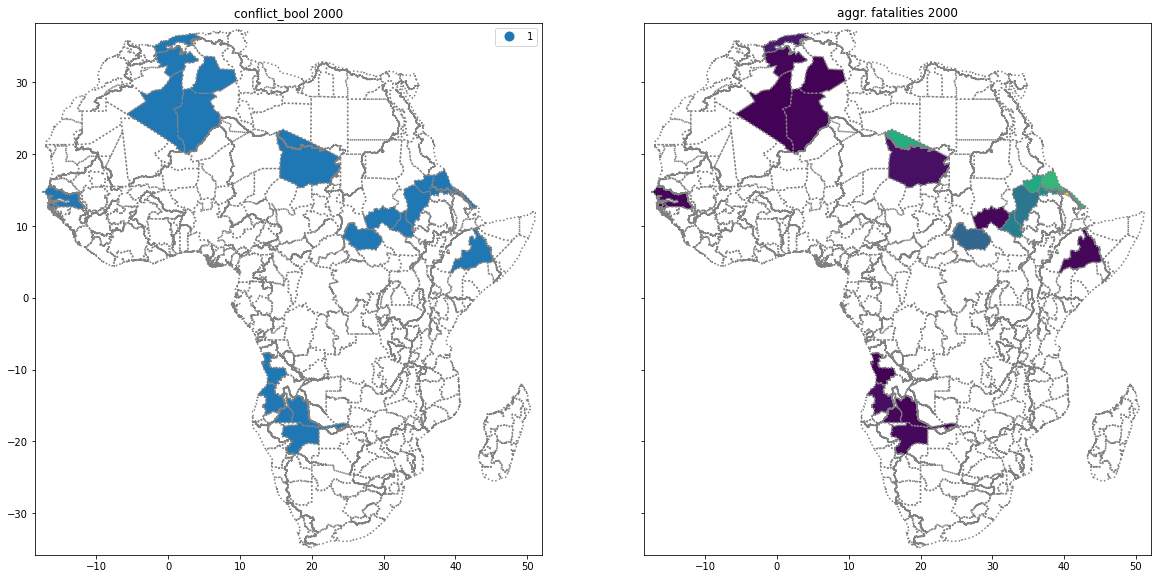

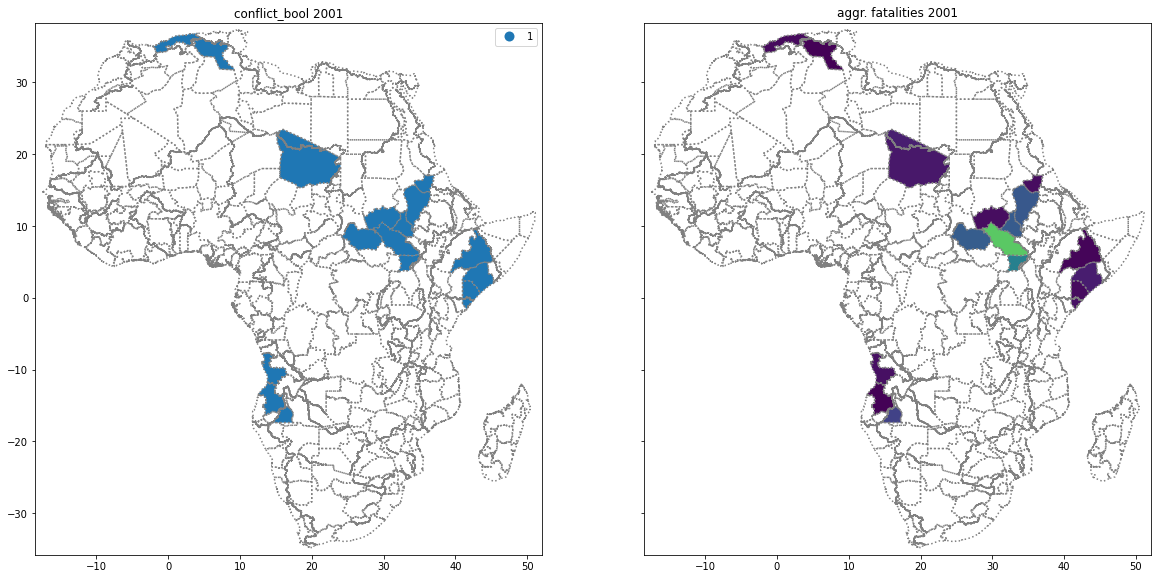

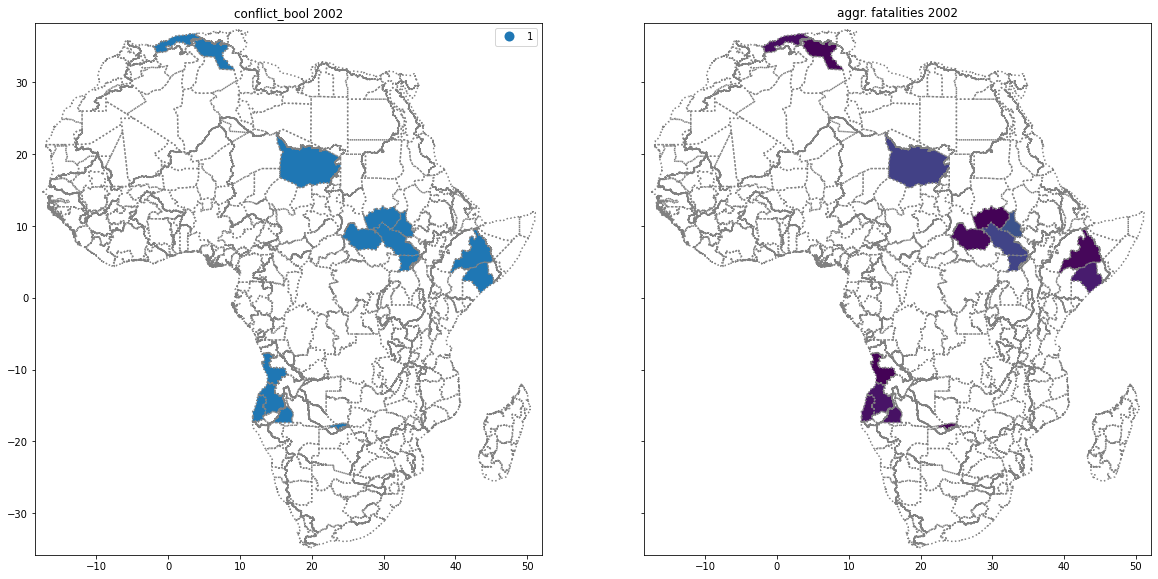

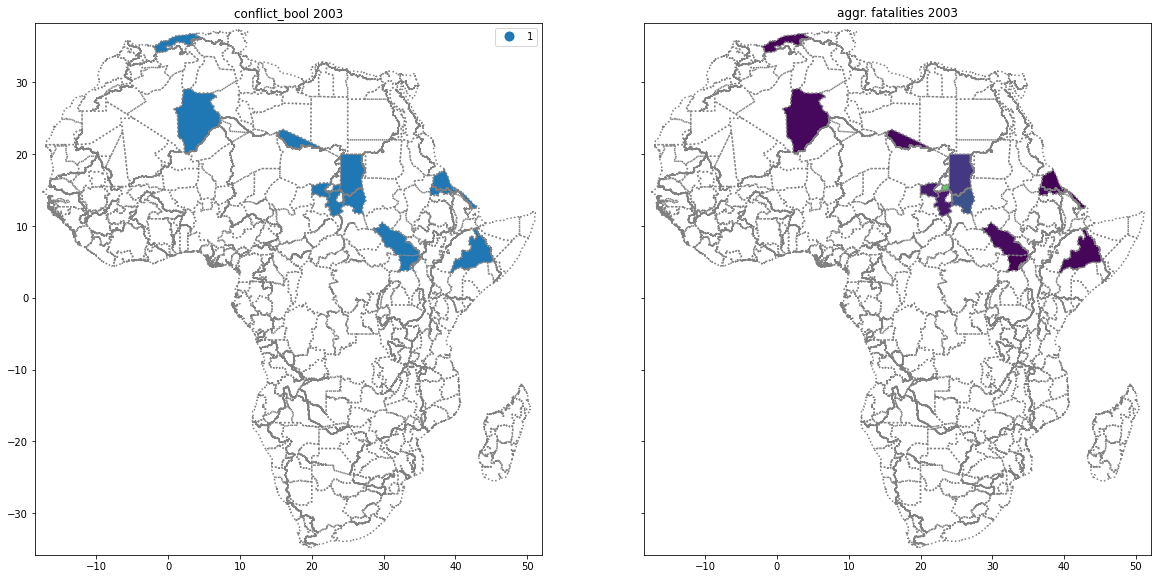

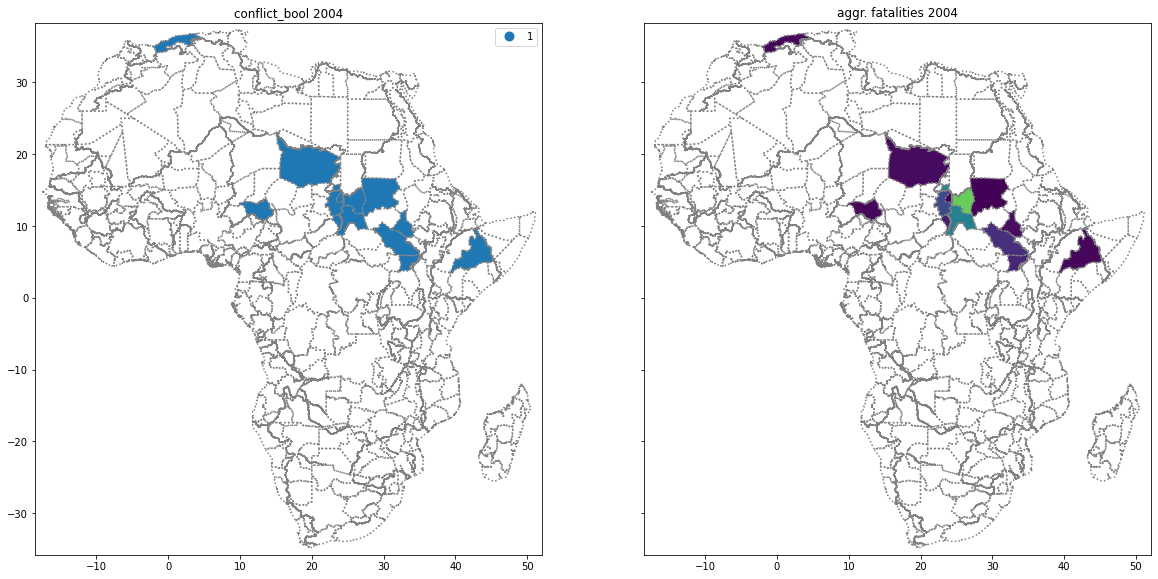

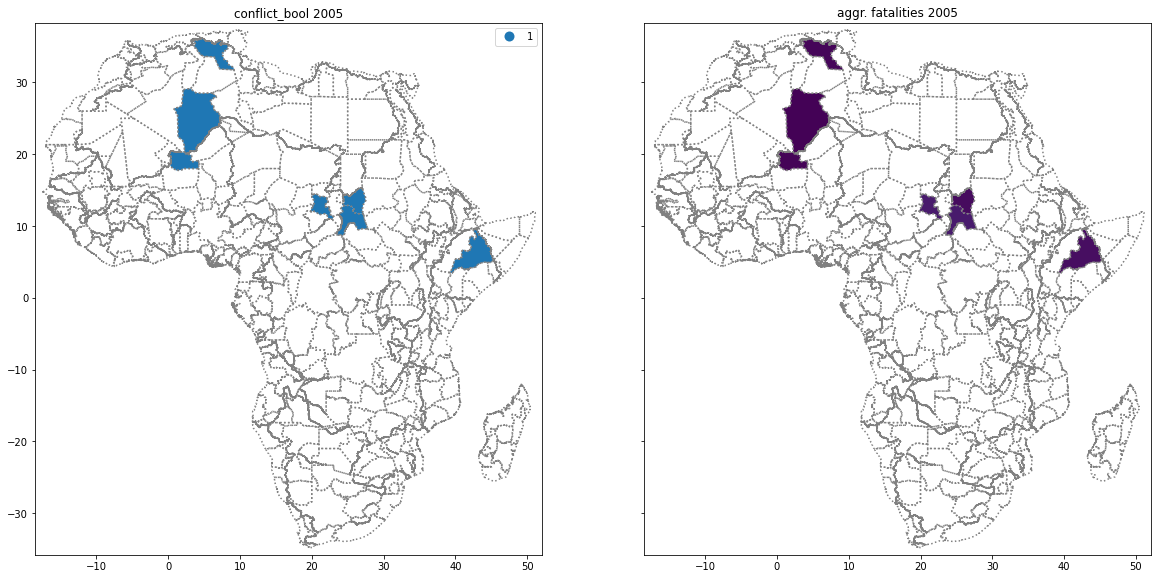

In [11]:
conflict_model.analysis.conflict_in_year_bool(conflict_gdf, extent_gdf, config, showing_plots=True, saving_plots=True)